<a href="https://colab.research.google.com/github/wear-Electroniks/pyTorch_projects/blob/main/finalized_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 2: Deep Learning with Images
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Eric-Tuan Le, Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any ways. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated. However feel free to change the number of epochs 

Each exercise must be implemented from scratch. Unless differently specified, only `Numpy`, `PyTorch` and `matplotlib` are allowed. We encourage to test the correctness of results using libraries.

In case you are suspected of plagiarism you might be requested to present your work in an one-to-one session
(date to be decided) demonstrating what you have implemented.



**Questions:**

[Question 1](#question1): Image, audio; all the same (15 points)

[Question 2](#question2): Denoising (25 points)

[Question 3](#question3): Auto-encoder (30 points)

[Question 4](#question4): Variational auto-encoder (30 points)

## Datasets

All the datasets must be contained in the `Datasets` folder at the same level of hierarchy as the notebook.
In this courswork you are going to use MNIST, CelebA, audio data and noisy images. Each dataset is used in a specific exercise. The data paths are already present in the code, please **do not** change it.

The Dataset (zipped) can be downloaded from here: http://geometry.cs.ucl.ac.uk/mlvc/courseworks/Datasets.zip

![cw2.png](attachment:cw2.png)

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [ ]:
import IPython
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
from skimage.metrics import peak_signal_noise_ratio
import os
import torchvision
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF

In [ ]:
# install prettytable and uncomment to use count_paramters function
from prettytable import PrettyTable 

In [ ]:
!pip install livelossplot

In [ ]:
# install livelossplot and uncomment below to plot losses live (while training) <- highly suggested
from livelossplot import PlotLosses

Set random seed

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Set device

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Create folder in which save models

In [ ]:
os.makedirs('models', exist_ok=True)

### Utility functions

In [ ]:
def plot_images(images, titles, texts):
    N_cols = len(images)
    N_rows = len(images[0])
    
    fig, axs = plt.subplots(N_rows, N_cols)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])
    
    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img_col) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()


def count_parameters(model):
    # you can use this function to print number parameters per layer
    # install prettytable and uncomment import to use count_paramters function
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## 1. Image, audio; all the same (15 points)
<a name='question1'></a>

[a)](#question1a) Implement a filter to remove low temporal frequencies (`highpass_fft_filter_audio`) from the audio file `audio.npy`, provided under `Datasets/Filtering/`. Plot the input and output of your filter as line graphs. (**2 points**) Implement a version using FFT (`highpass_fft_filter_audio`) and a version using moving average (`highpass_normal_filter_audio`) (**2 points**), discuss which version, when and why is better (**1 point**).

[b)](#question1b) Implement a filter to find vertical edges in an image. We provide a sample file `image.png` under
`Datasets/Filtering/` for testing. Apply your filter to this image and display the input and output of your filter. (**8 points**) Implement the filter without for loops (**2 points**).


In [ ]:
!wget 'http://geometry.cs.ucl.ac.uk/mlvc/courseworks/Datasets.zip'

--2021-12-24 14:10:33--  http://geometry.cs.ucl.ac.uk/mlvc/courseworks/Datasets.zip
Resolving geometry.cs.ucl.ac.uk (geometry.cs.ucl.ac.uk)... 128.16.15.132
Connecting to geometry.cs.ucl.ac.uk (geometry.cs.ucl.ac.uk)|128.16.15.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 649590840 (619M) [application/zip]
Saving to: ‘Datasets.zip’

Datasets.zip        100%[===================>] 619.50M  12.3MB/s    in 55s     

2021-12-24 14:11:29 (11.3 MB/s) - ‘Datasets.zip’ saved [649590840/649590840]



In [ ]:
!unzip '/content/Datasets.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Datasets/MNIST/validation/2799.jpg  
  inflating: Datasets/MNIST/validation/28.jpg  
  inflating: Datasets/MNIST/validation/280.jpg  
  inflating: Datasets/MNIST/validation/2800.jpg  
  inflating: Datasets/MNIST/validation/2801.jpg  
  inflating: Datasets/MNIST/validation/2802.jpg  
  inflating: Datasets/MNIST/validation/2803.jpg  
  inflating: Datasets/MNIST/validation/2804.jpg  
  inflating: Datasets/MNIST/validation/2805.jpg  
  inflating: Datasets/MNIST/validation/2806.jpg  
  inflating: Datasets/MNIST/validation/2807.jpg  
  inflating: Datasets/MNIST/validation/2808.jpg  
  inflating: Datasets/MNIST/validation/2809.jpg  
  inflating: Datasets/MNIST/validation/281.jpg  
  inflating: Datasets/MNIST/validation/2810.jpg  
  inflating: Datasets/MNIST/validation/2811.jpg  
  inflating: Datasets/MNIST/validation/2812.jpg  
  inflating: Datasets/MNIST/validation/2813.jpg  
  inflating: Datasets/MNIST/validation/2814.jpg  
  i

**Question 1.a**
<a name='question1a'></a>

Implement a filter to remove low temporal frequencies

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def highpass_fft_filter_audio(audio):
  #solution

  #compute FFT

  n = len(input_audio)
  fs = 44e3
  delta_t = 1/fs
  f_hat = np.fft.fft(input_audio, n) # fft
  power_spectral_density = f_hat*np.conj(f_hat)/n
  freq_axis = (1/(delta_t*n)) * np.arange(n)  # create frequncies axis
  L_half = np.arange(1, np.floor(n/2)) # plot only first half of frequencies

  # use threshold of PSD to filter the noise

  retained = power_spectral_density > 0.7 # find all frequencies with large power
  power_sd_clean = power_spectral_density*retained  # remove/ zero out the the weakers power spectral coefficients
  f_hat = f_hat * retained  # remove/ zero out the the weakers spectral coefficients
  filtered_audio = np.fft.ifft(f_hat) # inverse fft for filtered time-domain signal

  #end_solution

    
    
  return filtered_audio

In [ ]:
def highpass_normal_filter_audio(audio):
  filtered_audio = None
  #solution
  fc = 0.1 # Cutoff frequency
  t_b = 0.08  # Transition band
  L = int(np.ceil((5 / t_b)))
  if not L % 2: 
    L += 1  #L is odd.
  n = np.arange(L)
  
  # low-pass filter.
  h = np.sinc(2 * fc * (n - (L - 1) / 2))
  window = np.blackman(L)
  h = h * window
  h = h / np.sum(h)
  
  # Create a high-pass filter from the low-pass filter through spectral inversion.
  h = -h
  h[(L - 1) // 2] += 1

  tmp = np.convolve(input_audio, h)
  filtered_audio =tmp[31:-31]
  #end_solution   
    
  return filtered_audio

In [ ]:
audio_rate = 44e3   # The audio sample is assumed to have been acquired at 44Khz sampling rate

Load  audio from file

In [ ]:
# load input_audio from input_audio_filename
input_audio_filename = "./Datasets/Filtering/audio.npy"
input_audio = np.load(input_audio_filename)
print(f"Audio array shape: {input_audio.shape}")

# The audio sample played at 44khz sampling rate. Basically a 1 second noise sample. 
IPython.display.Audio(input_audio, rate=audio_rate)

Audio array shape: (1000,)


Run filtering with input data 

In [ ]:
input_audio = np.load(input_audio_filename)
filtered_audio = highpass_fft_filter_audio(input_audio)

In [ ]:
print("Original audio")
IPython.display.Audio(input_audio, rate=audio_rate)

Original audio


In [ ]:
print("Filtered audio")
IPython.display.Audio(filtered_audio, rate=audio_rate)

Filtered audio


/usr/local/lib/python3.7/dist-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


Plot the original audio and the filtered version

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


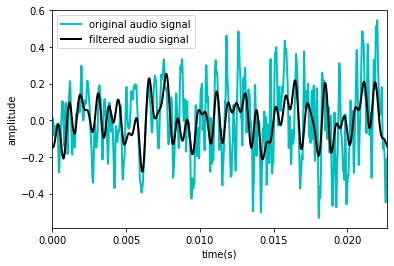

In [ ]:
# plot input_audio and filtered_audio

#solution
fs = audio_rate

samples = len(input_audio)
total_time_signal = samples/float(fs)

delta_t = 1/fs
time_sequence = np.arange(0,total_time_signal-delta_t, delta_t)

plt.plot(time_sequence, input_audio, color='c', LineWidth = 2, label='original audio signal')
plt.plot(time_sequence, filtered_audio, color='k', LineWidth = 2, label='filtered audio signal')
plt.xlim(time_sequence[0],time_sequence[-1])
plt.ylabel('amplitude')
plt.xlabel('time(s)')
plt.legend()

#end_solution


In [ ]:
input_audio = np.load(input_audio_filename)
filtered_audio = highpass_normal_filter_audio(input_audio)

1000

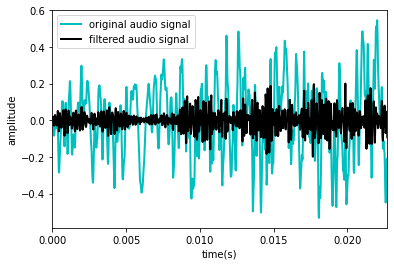

In [ ]:
# plot input_audio and filtered_audio

#solution
fs = audio_rate
delta_t = 1/fs

samples = len(input_audio)
total_time_signal = samples/float(fs)
time_sequence = np.arange(0,total_time_signal-delta_t, delta_t)

plt.plot(time_sequence, input_audio, color='c', LineWidth = 2, label='original audio signal')
plt.plot(time_sequence, filtered_audio, color='k', LineWidth = 2, label='filtered audio signal')
plt.xlim(time_sequence[0],time_sequence[-1])
plt.ylabel('amplitude')
plt.xlabel('time(s)')
plt.legend()
#end_solution


**Question 1.b**
<a name='question1b'></a>

Implement a filter to find vertical edges in an image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def detect_vertical_edges(image):
  #solution

  verticle_filter = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

  l,w,c = image.shape

  canvas = np.zeros_like(image)

  for row in range(3, l-2):
    for col in range(3, w-2):
      current_pixels = image[row-1:row+2, col-1:col+2,0]
      transformed_pixels = current_pixels*verticle_filter
      score = (transformed_pixels.sum()+4)/8
      canvas[row, col] = [score]*3
      filtered_image = canvas

  #end_solution

  return filtered_image

In [ ]:
input_image_filename = "./Datasets/Filtering/image.png"

Run filter over the input image

In [ ]:
input_image = np.asarray(PIL.Image.open(input_image_filename).convert('RGB'))
filtered_image = detect_vertical_edges(input_image)

Display the original image and its filtered version side by side

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

<Figure size 432x288 with 0 Axes>

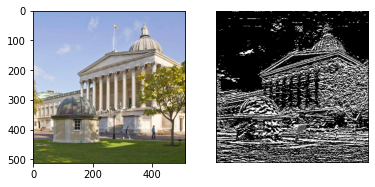

In [ ]:
# display input_image and filtered_image here

#solution
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axs = plt.subplots(1, 2) 
axs[0].imshow(input_image)
axs[1].imshow(filtered_image)
plt.axis('off')
plt.show()

#end_solution

## 2. Denoising (25 points)
<a name='question2'></a>

[a)](#question2a) Implement `denoiseGauss(image)` to denoise the image noisy `image.png` under `Filtering/` using a
5×5 Gaussian filter. (**5 points**)

[b)](#question2b) Implement a pyramidal encoder-decoder to denoise an image. We provide you pairs of noisy and
noise-free image patches of size 128×128 for training and testing, under `Datasets/Denoising/`. You may use all the infrastructure of `Pytorch`. The encoder and decoder must have at least 3 layers each. Please use ReLU non-linearities after each layer (**15 points**).
Please train for no more than 400 epochs.

[c)](#question2c) Write a markdown block in your notebook, comparing the Gaussian and encoder-decoder denoising
methods. Include example output images from each method and discuss which method performs better and where. You should write no more than half a page. (**5 points**)

**Question 2.a**
<a name='question2a'></a>

Implement the function to denoise the image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def gkern(l=5, sig=1.):
    
  #solution
  #l = 2 * int(2 * sigma + 0.5) + 1
  out_kernel = np.zeros((l, l), np.float32)
  m = l//2
  n = l//2  
  for x in range(-m, m+1):
      for y in range(-n, n+1):
          x1 = 2*np.pi*(sig**2)
          x2 = np.exp(-(x**2 + y**2)/(2* sig**2))
          out_kernel[x+m, y+n] = (1/x1)*x2
  #end_solution
  
  return out_kernel

def denoise_gauss(image):
    
  #solution
  kernel =gkern()
  denoised_image = np.zeros_like(image, dtype=np.float32)

  kernel_h = kernel.shape[0]
  kernel_w = kernel.shape[1]

  h = kernel_h // 2
  w = kernel_w // 2

  for c in range(3):
      for i in range(h, image.shape[0]-h):
        for j in range(w, image.shape[1]-w):
            x = image[i-h:i+kernel_h-h, j-w:j+kernel_w-w,c]
            x = x.flatten()*kernel.flatten()
            denoised_image[i,j,c] = x.sum()

  #end_solution

  #denoised_image.astype(np.uint8)
  return denoised_image

Load input image from file

In [ ]:
noisy_image_filename = "./Datasets/Filtering/noisy_image.png"
#noisy_image_filename = "/content/Datasets/Denoising/input_noisy_images/101.png"

Filter the input image

In [ ]:
noisy_image = np.asarray(PIL.Image.open(noisy_image_filename).convert('RGB'))
denoised_image = denoise_gauss(noisy_image).astype(noisy_image.dtype)


In [ ]:
#plot_images([[noisy_image, noisy_image], [denoised_image, denoised_image]], ['noisy', 'denoised'], None)

Display the input image and its filtered version side by side

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

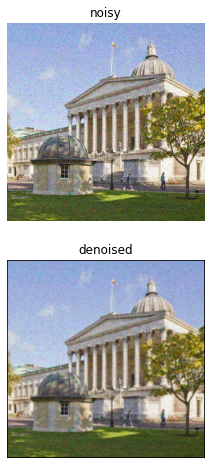

In [ ]:
# display input_image and denoised_image here
#solution

fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2, 1, 1)
plt.imshow(noisy_image)
plt.axis('off')
plt.title("noisy")
fig.add_subplot(2, 1, 2)
plt.imshow(denoised_image)
plt.axis('off')
plt.title("denoised")
plt.show()
#end_solution


**Question 2.b**
<a name='question2b'></a>

Implement dataset class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class DenoisingDB(Dataset):
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()
        
        #solution 
        noisy = os.listdir(input_imgs_path)
        clean = os.listdir(cleaned_imgs_path)
        dataset_path = [input_imgs_path, cleaned_imgs_path]

        self.images = []
        self.targets = []
        self.transform = transforms.Compose([transforms.ToPILImage(),
                    transforms.CenterCrop((256,256)),
                    transforms.ToTensor()])
        for i, j in zip(noisy,clean):
            image = np.asarray(PIL.Image.open(os.path.join(dataset_path[0],i)).convert('RGB'))
            target = np.asarray(PIL.Image.open(os.path.join(dataset_path[1],j)).convert('RGB'))
            self.images.append(image)
            self.targets.append(target)
        
        #end_solution

    def __len__(self):
        
        #solution

        length = len(self.targets)

        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution
        input_image = self.images[idx][:]
        #input_image = np.asarray(input).astype(np.uint8).reshape((256, 256, 3))
        target_image = self.targets[idx][:]
        input_image = self.transform(input_image)
        target_image = self.transform(target_image)
        #end_solution

        
        return (input_image, target_image)

Implement the Encoder network: 5 levels and double the number of internal activations when reducing the spatial resolution. Please use ReLU non-linearities.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class Encoder(Module):
    
    def __init__(self):
      super(Encoder, self).__init__()
        
      #solution
      # encoder layers
      self.enc1 = nn.Conv2d(3, 512, kernel_size=3, padding=1)
      self.enc2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
      self.enc3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
      self.enc4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
      self.pool = nn.MaxPool2d(2, 2)
      self.bn1 = nn.BatchNorm2d(512)
      self.bn2 = nn.BatchNorm2d(256)
      self.bn3 = nn.BatchNorm2d(128)
      self.bn4 = nn.BatchNorm2d(64)        
    
      #end_solution


    def forward(self,high_res_image):
      #solution
      high_res_image = F.relu(self.enc1(high_res_image))
      high_res_image = self.bn1(high_res_image)
      high_res_image = self.pool(high_res_image)
      high_res_image = F.relu(self.enc2(high_res_image))
      high_res_image = self.bn2(high_res_image)
      high_res_image = self.pool(high_res_image)
      high_res_image = F.relu(self.enc3(high_res_image))
      high_res_image = self.bn3(high_res_image)
      high_res_image = self.pool(high_res_image)
      high_res_image = F.relu(self.enc4(high_res_image))
      high_res_image = self.bn4(high_res_image)
      low_res_image = self.pool(high_res_image) # the latent space representation

      #end_solution
      
      return low_res_image

Implement the Decoder network: 5 levels and half the number of internal activations when increasing the spatial resolution. Please use ReLU non-linearities.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class Decoder(Module):
  def __init__(self):
    super(Decoder, self).__init__()
    #solution
    # decoder layers
    self.dec1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  
    self.dec2 = nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2)
    self.dec3 = nn.ConvTranspose2d(128, 256, kernel_size=2, stride=2)
    self.dec4 = nn.ConvTranspose2d(256, 512, kernel_size=2, stride=2)
    self.out = nn.Conv2d(512, 3, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(64) 

    #end_solution 

  def forward(self, low_res_image):    
    #solution
    low_res_image = F.relu(self.dec1(low_res_image))
    low_res_image = self.bn4(low_res_image)
    low_res_image = F.relu(self.dec2(low_res_image))
    low_res_image = self.bn3(low_res_image)
    low_res_image = F.relu(self.dec3(low_res_image))
    low_res_image = self.bn2(low_res_image)
    low_res_image = F.relu(self.dec4(low_res_image))
    low_res_image = self.bn1(low_res_image)
    denoised_image = torch.sigmoid(self.out(low_res_image))
    #end_solution

    return denoised_image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def loss_function(input,target):
    
  #solution

  # the loss function
  loss = nn.MSELoss()(input, target)
  #end_solution

  return loss

Paths input data

In [ ]:
cleaned_imgs_path = '/content/Datasets/Denoising/target_clean_images/'
input_imgs_path = '/content/Datasets/Denoising/input_noisy_images/'

Write the training loop

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
docs_dataset = DenoisingDB(input_imgs_path, cleaned_imgs_path)

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
#solution



NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
BATCH_SIZE =1 

train_loader = DataLoader(docs_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_loss = []
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = optim.Adam(params_to_optimize, lr=1e-3)

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data, target in train_loader:
        noisy_image = data
        target = target
        # for inspection purpose        
        '''print(target.shape,noisy_image.shape)
        noisy_image = [noisy_image[i].cpu().detach().numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(target))]
        denoised_image = [target[i].cpu().detach().numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(target))]
        fig = plt.figure(figsize=(8, 8))
        fig.add_subplot(2, 1, 1)
        plt.imshow(noisy_image[0])
        plt.axis('off')
        plt.title("noisy")
        fig.add_subplot(2, 1, 2)
        plt.imshow(denoised_image[0])
        plt.axis('off')
        plt.title("denoised")
        plt.show()'''       
        #########################
        noisy_image = noisy_image.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        low_resolution_image = encoder(noisy_image)
        output = decoder(low_resolution_image)
        loss = loss_function(output, target)
        loss.backward()
        # backpropagation
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    print(f'Epoch {epoch+1} of {NUM_EPOCHS}, Train Loss: {loss:.5f}')
    
    #if epoch % 10 == 0:
      #output = output.view(output.size(0), 3, 256, 256).cpu().data
      #save_decod_img(output, f'/content/Datasets/Denoising/denoised_image_{epoch}.png')
    train_loss
    #end_solution

Epoch 1 of 5, Train Loss: 0.07955
Epoch 2 of 5, Train Loss: 0.05596
Epoch 3 of 5, Train Loss: 0.05080
Epoch 4 of 5, Train Loss: 0.04598
Epoch 5 of 5, Train Loss: 0.04184


Save the model (needed for marking)

In [ ]:
torch.save({'encoder':encoder, 'decoder':decoder}, 'models/ex2b.pth')

Load trained model

In [ ]:
state_dict = torch.load('models/ex2b.pth')
encoder = state_dict['encoder'].to(device)
decoder = state_dict['decoder'].to(device)

Plot 5 input images and their relative denoised images side by side.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

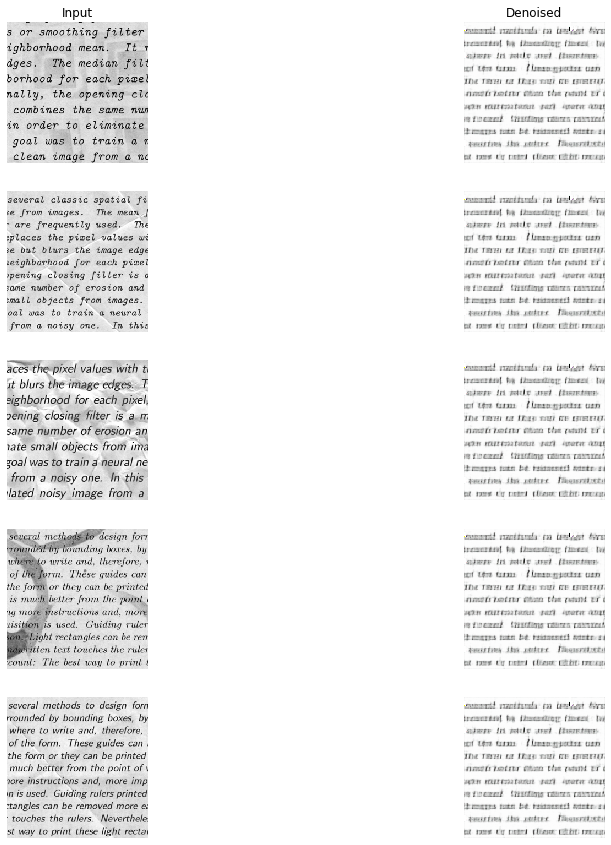

In [ ]:
#solution
images_ae1 = []
img = []
for idx in np.arange(5):
  img.append(np.asarray(docs_dataset[idx][0]).swapaxes(0,1).swapaxes(1,2))
  with torch.no_grad():
    image = docs_dataset[idx][0].unsqueeze(0)
    image = image.to(device)
    images_ae1.append(decoder(encoder(image)).squeeze(0))

#images_reshaped = [i.numpy() for i in images_reshaped]


images_ae2 = [images_ae1[idx].cpu().detach().numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(images_ae1))]
img1 = [img, images_ae2]
titles = ['Input', 'Denoised']
plot_images(img1, titles, None)  
#end_solution


**Question 2.c**
<a name='question2c'></a>

Load trained model

In [ ]:
state_dict = torch.load('models/ex2b.pth')
encoder = state_dict['encoder'].to(device)
decoder = state_dict['decoder'].to(device)

Compute images for both the AE and Gaussian Kernels algorithm from `images`.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
images = [docs_dataset[i][0].to(device) for i in range(5)]
targets = [docs_dataset[i][1].to(device) for i in range(5)]
images_ae = []
images_gauss = []

#solution

for i,v in enumerate(images):
  k = v.cpu().detach().numpy().swapaxes(0,1).swapaxes(1,2)
  n = denoise_gauss(k).astype(k.dtype)
  images_gauss.append(n)
  #images_gauss.append(denoise_gauss(v.cpu().detach().numpy().swapaxes(0,1).swapaxes(1,2)))
  images_ae.append(decoder(encoder(v.unsqueeze(0))).squeeze(0))
#end_solution



Plot images and PSNR

In [ ]:
imgs_plot = [ el.detach().squeeze().cpu().numpy().swapaxes(0,1).swapaxes(1,2) for el in images]
tgts_plot = [ el.detach().squeeze().cpu().numpy().swapaxes(0,1).swapaxes(1,2) for el in targets]
images_ae = [images_ae[i].cpu().detach().numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(images_ae))]

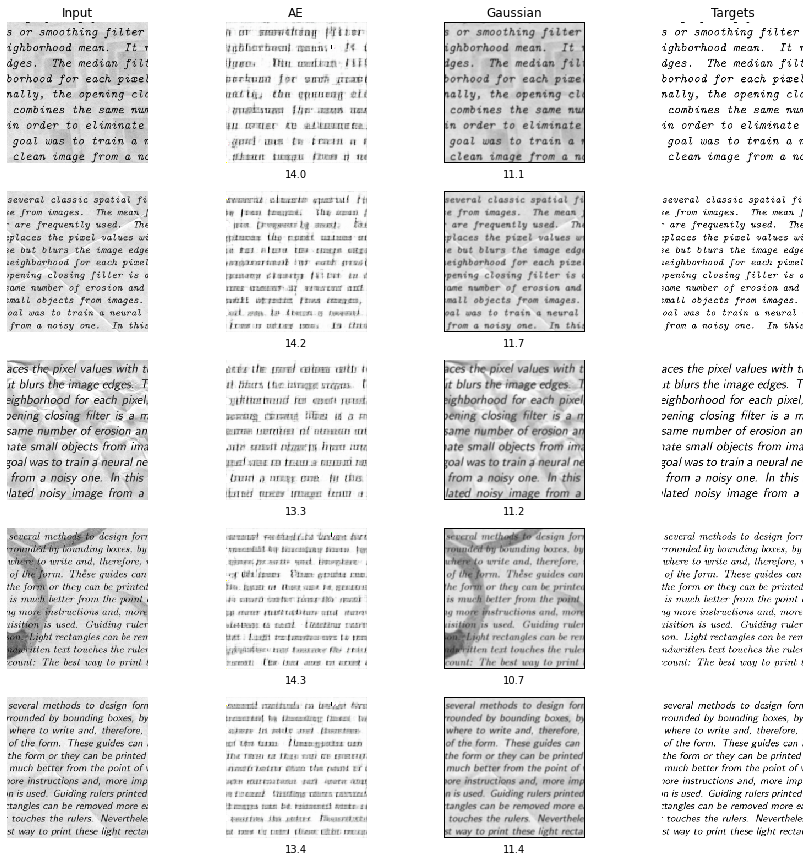

In [ ]:
psnrs = [ 0.0 for el in targets]
for i in range(len(tgts_plot)):
    psnr_ae    = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
    pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])
    psnrs[i] = ['', psnr_ae, pnsr_gauss, '']


img = [imgs_plot, images_ae, images_gauss, tgts_plot]
titles = ['Input', 'AE', 'Gaussian', 'Targets']
texts = psnrs
plot_images(img, titles, texts)
plt.show()

Comment on the results obtained from the plot above.

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_: Images are corrupted due to various types of
noise which results degradation in their quality in differet areas. For example, it is difficult for practitioners to diagnose the dieases even from 4D-CT or ultrasound images. Deep autoencoder based denosing is efficient technique to deal with different types of noise such as additive white Gaussian and multiplicative speckle noises. The present simulation based on gaussian filtering and deep autoencoder  methods show that gaussian based filter is efficient and competitive in comparison with deep autoencoder methods because of the deep learning model trained on smaller number of epochs.

Deep learning model can outperform the gaussian filtering method if the model is trained for longer time or increasing its complexity.



## 3. Auto-encoder (30 points)
<a name='question3'></a>

[a)](#question3a) Implement a convolutional auto-encoder (AE). The loss between in and output should be **L2**. You can make use of all the convolution, pooling, back-propagation and build-in functionality of `Pytorch` here. (**15 points**)
$$
||I −dec(enc(I))||^2_2
$$

[b)](#question3b) Test it on the MNIST (`Datasets/MNIST/`) dataset by encoding and decoding their first 5 samples. Compile a document showing, for each sample, the input and the AE reconstruction, side-by-side. (**5 points**)
Please train for no more than 100 epochs.

[c)](#question3c) Implement an auto-encoder (AE) and train it on CelebA. Choose the loss you deem more appropriate. Output 5 images from the AE you trained.  (**5 points**)

Please train it for no longer than 400 epochs.


[d)](#question3d) Discuss your design choices for Q3a and Q3c. Are the models different? Why? Discuss in no more than 15 sentences. If needed add plots and a demo. (**5 points**)



**Question 3.a**
<a name='question3a'></a>

Implement a convolutional auto-encoder

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class AutoEncoder(Module):
    
    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        #self.bottleneck_size = 64
        self.channel_size = channel_size
        
        #solution

        self.encod = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(self.channel_size, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, self.bottleneck_size, 7)
        )
        self.decod = nn.Sequential(
            nn.ConvTranspose2d(self.bottleneck_size, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, self.channel_size, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )


        #end_solution

    
    def encoder(self,image):
        
        #solution
        code = self.encod(image)

        #end_solution

        
        return code
    
    def decoder(self,code):
        
        #solution

        decoded_image = self.decod(code)

        #end_solution

        
        return decoded_image
    
    def forward(self,image):
        
        #solution

        coded = self.encoder(image)
        decoded_image = self.decoder(coded)

        #end_solution
        
        return decoded_image

**Question 3.b**
<a name='question3b'></a>

Implement the dataset class to load MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MNIST(Dataset):
    
    def __init__(self, dataset_path):
        
        #solution

        self.images = [cv2.imread(os.path.join(dataset_path,i)) for i in os.listdir(dataset_path)]
        self.transform = transforms.Compose([transforms.ToPILImage(),
                    transforms.ToTensor()])
        #end_solution


    def __len__(self):
        
        #solution

        length = len(self.images)

        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution

        image = self.images[idx]
        image = self.transform(image)
        #image = torch.flatten(input)
        #end_solution

        
        return image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def reconstruction_loss(input,target):
    
    #solution

    recon_loss = nn.MSELoss()(input,target)

    #end_solution

    
    return recon_loss

Create dataloaders for training and validation

In [ ]:
mnist_train_data_path = "./Datasets/MNIST/train/"
mnist_train_dataset = MNIST(mnist_train_data_path)

mnist_validation_data_path = "./Datasets/MNIST/validation/"
mnist_validation_dataset = MNIST(mnist_validation_data_path)


Train the AE on MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
mnist_autoencoder = None # your model (assign below)

#solution
mnist_autoencoder = AutoEncoder(64,3)
mnist_autoencoder.to(device)

BATCH_SIZE = 50
train_loader = DataLoader(mnist_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = optim.Adam(mnist_autoencoder.parameters(), lr=0.0005, weight_decay=1e-05)  

NUM_EPOCHS = 5
train_loss = []
for epochs in range(NUM_EPOCHS):
  running_loss = 0
  for img in train_loader:
    img = img.to(device)
    optimizer.zero_grad()
    #img = img.view(img.size(0), -1) 
    outputs = mnist_autoencoder(img)
    loss = reconstruction_loss(img, outputs)
    # backpropagation
    loss.backward()
    # update the parameters
    optimizer.step()
    running_loss += loss.item()

  loss = running_loss /14934
  train_loss.append(loss)
  print('Epoch {} of {}, Train Loss: {:.3f}'.format(epochs+1, NUM_EPOCHS, loss))

  #if epochs % 10 == 0:
   # save_mnist_img(outputs.cpu().data, f'/content/Datasets/MNIST/Autoencoder_image_{epochs}.png')
#end_solution


Epoch 1 of 5, Train Loss: 0.003
Epoch 2 of 5, Train Loss: 0.001
Epoch 3 of 5, Train Loss: 0.000
Epoch 4 of 5, Train Loss: 0.000
Epoch 5 of 5, Train Loss: 0.000


Save trained model (needed for marking)

In [ ]:
torch.save(mnist_autoencoder, './models/ex3.pth')

Load trained model

In [ ]:
mnist_autoencoder = torch.load('models/ex3.pth')

Showing, for 5 samples in the validation set, the input and the AE reconstruction, side-by-side.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

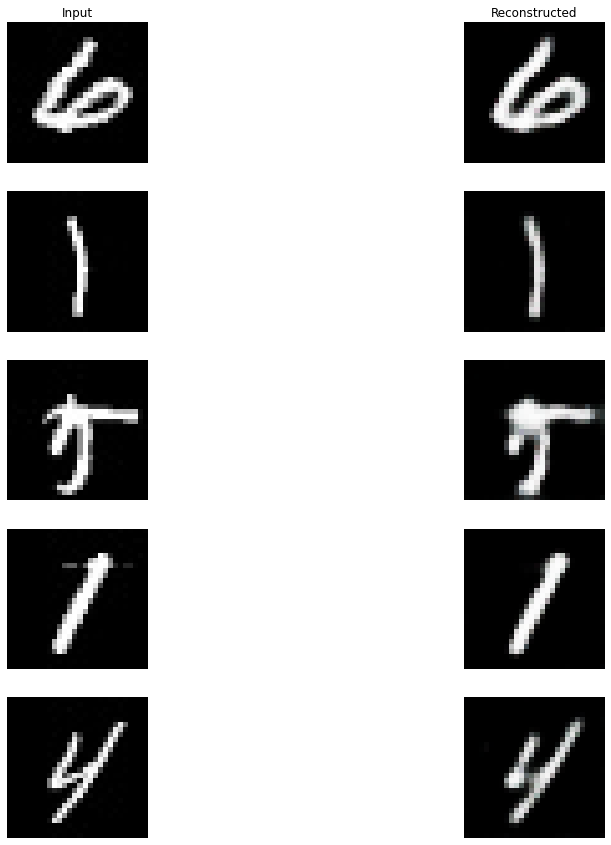

In [ ]:
indices = np.random.choice(range(len(mnist_validation_dataset)), 5, replace=False)
mnist_random_images = [mnist_validation_dataset[idx] for idx in indices]


#solution
new_image = []
for image in mnist_random_images:
  with torch.no_grad():
    image = image.unsqueeze(0)
    image = image.to(device)
    new_image.append(mnist_autoencoder(image))
    #save_decod_img(new_image.cuda().data, f'/content/Datasets/MNIST/Autoencoder_test_image_{i}.png', 3, 28)

images_ae = [new_image[i].cpu().detach().numpy().squeeze(0).swapaxes(0,1).swapaxes(1,2) for i in range(len(new_image))]
input_images = [mnist_random_images[i].numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(new_image))]


img1 = [input_images, images_ae]
titles = ['Input', 'Reconstructed']
plot_images(img1, titles, None)
#end_solution


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

**Question 3.c**
<a name='question3c'></a>

Write your AE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class CebelAAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size
        
        #solution
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(self.channel_size, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section # 3*3*32 if input is of 28*28 size, as its size is reduced to  L =3, H=3
        self.encoder_lin = nn.Sequential(
            nn.Linear(27*22*32, 128),
            nn.ReLU(True),
            nn.Linear(128, self.bottleneck_size)
        )
        self.decoder_lin = nn.Sequential(
            nn.Linear(self.bottleneck_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 27*22*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 27, 22))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, self.channel_size, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
        #end_solution
    
    def encoder(self,image):
        
        #solution

        x = self.encoder_cnn(image)
        #x = F.adaptive_avg_pool2d(x, 1).reshape(1, -1)
        x = self.flatten(x)
        code = self.encoder_lin(x)

        #end_solution

        
        return code
        
    def decoder(self,code):
        #solution

        x = self.decoder_lin(code)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        decoded_image = torch.sigmoid(x)

        #end_solution

        
        return decoded_image
    
    def forward(self, image):
        
        #solution

        encoded = self.encoder(image)

        decoded_image = self.decoder(encoded)

        #end_solution

        
        return decoded_image

    

Implete CelebA dataset class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class CelebA(Dataset):
    
    def __init__(self, dataset_path):
        
        #solution

        self.images = [np.asarray(PIL.Image.open((os.path.join(dataset_path,i))).convert('RGB')) for i in os.listdir(dataset_path)]
        self.transform = transforms.Compose([transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.ConvertImageDtype(torch.float)])  #transforms.Resize(size=(64,64),interpolation=PIL.Image.BICUBIC , max_size=None, antialias=None),

                            #,

    def __len__(self):
        
        #solution

        length = len(self.images)

        #end_solution

        
        return length


    def __getitem__(self, idx):
        
        #solution

        image = self.images[idx]
        image =self.transform(image)
       
        #end_solution

        
        return image


Create train and validation data loaders

In [ ]:
celeba_train_data_path = "./Datasets/CelebA/train_subset/"
celeba_train_dataset = CelebA(celeba_train_data_path)

celeba_validation_data_path = "./Datasets/CelebA/val_subset/"
celeba_validation_dataset = CelebA(celeba_validation_data_path)

Write your losses here

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def reconstruction_loss(input,target):
    
    #solution

    recon_loss = nn.MSELoss()(input,target)

    #end_solution

    
    return recon_loss


Train AE on CelebA

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
celeba_ae = None # create the AE and assign it to this

#solution
celeba_ae = CebelAAE(16, 3)
celeba_ae.to(device)

BATCH_SIZE = 10

optimizer = optim.Adam(celeba_ae.parameters(), lr=0.0005, weight_decay=1e-05)  
train_loader = DataLoader(celeba_train_dataset, batch_size=BATCH_SIZE, shuffle=True)


NUM_EPOCHS = 3
train_loss = []
for epochs in range(NUM_EPOCHS):
  running_loss = 0
  for img in train_loader:
    # Move tensor to the proper device
    img = img.to(device)
    optimizer.zero_grad()
    output = celeba_ae(img)
    #print('output: ', output.shape, 'image input: ', img.shape)
    #break
    loss = reconstruction_loss(img, output)
    # backpropagation
    loss.backward()
    # update the parameters
    optimizer.step()
    running_loss += loss.item()

  loss = running_loss /len(train_loader)
  train_loss.append(loss)
  print('Epoch {} of {}, Train Loss: {:.3f}'.format(epochs+1, NUM_EPOCHS, loss))

  #if epochs % 10 == 0:
  #  output = output.view(output.size(0), 3, 64, 64).cpu().data
  # save_decod_img(output, f'/content/Datasets/MNIST/celebratey_image_{epochs}.png')

#end_solution




KeyboardInterrupt: ignored

In [ ]:
torch.save(celeba_ae, 'models/ex_3_ae.pth')

In [ ]:
celeba_ae = torch.load("models/ex_3_ae.pth")

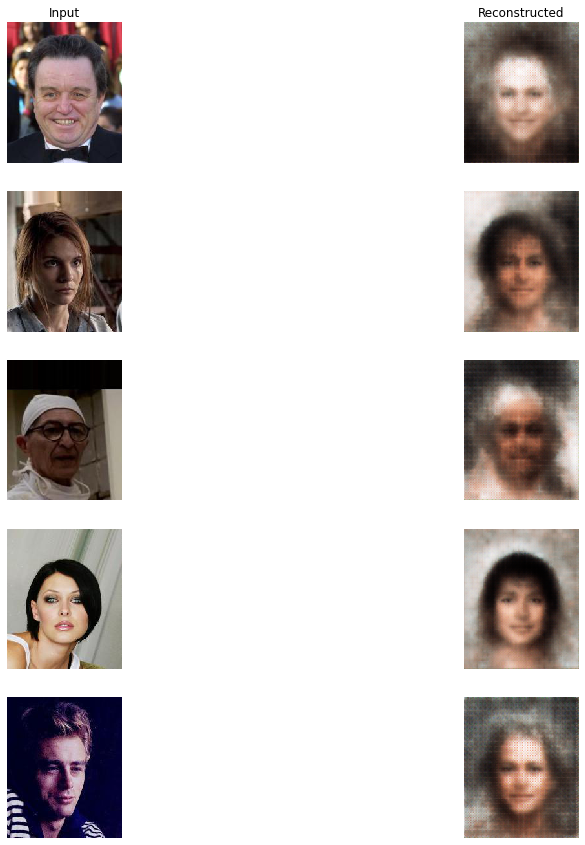

In [ ]:
indices = np.random.choice(range(len(celeba_validation_dataset)), 5, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]


#solution
new_image = []
for i in celeba_random_images:
  with torch.no_grad():
    image = (i.unsqueeze(0)).to(device)
    new_image.append(celeba_ae(image))
    #save_decod_img(new_image.cpu().data, f'/content/Datasets/CelebA/celebratey_test_image_{i}.png', 3, (new_image.squeeze(0)).shape[1])
#end_solution
images_ae = [new_image[i].cpu().detach().numpy().squeeze(0).swapaxes(0,1).swapaxes(1,2) for i in range(len(new_image))]
celeba_random_images = [celeba_random_images[i].numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(new_image))]


img1 = [celeba_random_images, images_ae]
titles = ['Input', 'Reconstructed']
plot_images(img1, titles, None)  



**Question 3.d**
<a name='question3d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 
The autoencoders used in Q3a and Q3c are different. There are 3 convolutional layers in encoding and decoding sections of autoencoder[Q3a]. Although, there are same number of convolutional layers in autoencoder in [Q3c] but batch normalization layer is added after every convolutional layer to improve the convergence speed of the model. 

- Moreover, batch normalization reduces the internal covariant shift, dependence of gradients on the scale of the parameters or their initial values, the need for dropout, photometric distortions, and regularizes the model. 

- Different models are used in order to examine the effect of different types of layers and similiar layers but with differnt count on the performance of model. 

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

## 4. Variational auto-encoder (30 points)
<a name='question4'></a>

[a)](#question4a) Implement a Variational Auto-Encoder (VAE). (**10 points**)

[b)](#question4b) Train and test it on the CelebA dataset by **generating 5 samples**. (**10 points**)

Please train it for no longer than 400 epochs.


[c)](#question4c) Compare samples from the VAE to the samples of the AE (Q3c), by **generating 10 samples** and explain in one sentence what is the difference. (**5 points**)

[d)](#question4d) Explain the main differences between Adam and SGD (**1 points**). Discuss which are the terms used by Adam and what role they play (**1 points**). Prepare a demo to show the difference between training a network with ADAM vs SGD. Show the loss curves, discuss what are the differences and why (**3 points**). (total 5)


**Question 4.a**
<a name='question4a'></a>

Create the VAE class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class VAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size
           
        #solution
        # encoder
        self.c=16
        self.enc1 = nn.Conv2d(in_channels=self.channel_size, out_channels=self.c, kernel_size=4, stride=2, padding=1) # out: c x 32 x 32
        self.enc2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1) # out: c x 16 x 16
        self.fc_mu = nn.Linear(in_features=self.c*2*54*44, out_features=self.bottleneck_size)
        self.fc_logvar = nn.Linear(in_features=self.c*2*54*44, out_features=self.bottleneck_size)

        self.fc = nn.Linear(in_features=self.bottleneck_size, out_features=self.c*2*54*44)
        self.dec1 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(in_channels=self.c, out_channels=self.channel_size, kernel_size=4, stride=2, padding=0)  

        #end_solution

    
    def encoder(self,image):
        
        #solution
        x = F.relu(self.enc1(image))
        x = F.relu(self.enc2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        mu = self.fc_mu(x)
        var = self.fc_logvar(x)
        std =var.mul(0.5).exp_() #  torch.exp(0.5*var)
        #x = self.enc3(x).view(-1, 2, self.bottleneck_size)
        #end_solution
   
        return mu, std
    
    def reparametrization_trick(self,mu,std):
        
        #solution
        eps = torch.randn_like(std) # torch.empty_like(std).normal_()
        z = mu + (eps * std) # sampling as if coming from true input space
        #end_solution
        return z
    
    def decoder(self,code):
        #solution
        # decoding
        x = self.fc(code)
        x = x.view(x.size(0), self.c*2, 54, 44)
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        decoded_image = torch.sigmoid(x)
        #end_solution
        
        return decoded_image
    
    def forward(self, image):
        
        #solution
        mu,std = self.encoder(image)
        sample = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(sample)

        #end_solution

        
        return decoded_image, mu, std

**Question 4.b**
<a name='question4b'></a>

Implement your losses here

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def reconstruction_loss(input,target):
    
    #solution

    recon_loss = nn.MSELoss()(input,target)
    #recon_loss = F.binary_cross_entropy(input.view(-1, 3*4096), target.view(-1, 3*4096), reduction='sum')

    #end_solution

    
    return recon_loss

def kl_divergence_loss(mu,std):
    
    #solution

    var = 2*torch.log(std)

    kl_loss = -0.5 * torch.sum(1+(var)-(mu.pow(2))-var.exp())

    #kl_loss = nn.KLDivLoss()(mu, std) var.mul(0.5).exp_()

    #kl_loss =torch.mean(-0.5 * torch.sum(1 + std-mu**2-std.exp(), dim = 1), dim = 0)

    #end_solution

    
    return kl_loss

Train your VAE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
celeba_vae = None # your model (assign it below)

#solution

celeba_vae = VAE(64,3)
celeba_vae.to(device)

optimizer = optim.Adam(params=celeba_vae.parameters(), lr=0.0005, weight_decay=1e-5)

# set to training mode
celeba_vae.train()

train_loss_avg = []

print('Training ...')
num_epochs = 3

train_loader = DataLoader(celeba_train_dataset, batch_size=4, shuffle=True) 

for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    for image_batch in train_loader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction

        

        image_batch_recon, latent_mu, latent_std = celeba_vae(image_batch)
        reconstuct_loss = reconstruction_loss(image_batch_recon, image_batch)
        kl_loss = kl_divergence_loss(latent_mu, latent_std)
        # backpropagation loss.requires_grad = True
        #loss.requires_grad = True    #loss = Variable(loss, requires_grad = True)
        loss = reconstuct_loss + kl_loss
        optimizer.zero_grad()
        loss.backward()
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1

        #print(num_batches)
        
    train_loss_avg[-1] /= len(image_batch)
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
#end_solution



Training ...
Epoch [1 / 3] average reconstruction error: 135.990247
Epoch [2 / 3] average reconstruction error: 57.826587
Epoch [3 / 3] average reconstruction error: 57.801825


Save model (needed for marking)

In [ ]:
torch.save(celeba_vae, 'models/ex4_vae.pth')

Load pretrained model

In [ ]:
celeba_vae = torch.load("models/ex4_vae.pth")

Generate and display 10 samples

In [ ]:
indices = np.random.choice(range(len(celeba_validation_dataset)), 10, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]
#transforms.ToPILImage(),

batch = torch.stack(celeba_random_images, dim=0)
pred_img = []


for i in celeba_random_images:
  with torch.no_grad():
    i = (i.unsqueeze(0)).to(device)
    pred_img.append(celeba_vae(i)[0])

imgs_plot = [celeba_random_images[i].numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(pred_img))]
#imgs_plot = [el.cpu().squeeze().numpy() for el in batch.permute(0,2,3,1)]
pred_plot = [pred_img[i].cpu().detach().numpy().squeeze(0).swapaxes(0,1).swapaxes(1,2) for i in range(len(pred_img))]

img = [imgs_plot, pred_plot, ]
plot_images(img, ['input','reconstructed'], None)
plt.show()
plt.close()

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
number_of_samples = 5


#solution

indices = np.random.choice(range(len(celeba_validation_dataset)), number_of_samples, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]

batch = torch.stack(celeba_random_images, dim=0)
pred_img = []
for i in celeba_random_images:
  with torch.no_grad():
    i = (i.unsqueeze(0)).to(device)
    pred_img.append(celeba_vae(i)[0])

imgs_plot = [celeba_random_images[i].numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(pred_img))]
pred_plot = [pred_img[i].cpu().detach().numpy().squeeze(0).swapaxes(0,1).swapaxes(1,2) for i in range(len(pred_img))]

img = [imgs_plot, pred_plot, ]
plot_images(img, ['input','reconstructed'], None)
plt.show()
plt.close()

#end_solution

Save the AE model (needed for marking)

**Question 4.c**
<a name='question4c'></a>

Load the VAE and AE model

In [ ]:
celeba_ae = torch.load('models/ex_3_ae.pth')
celeba_vae = torch.load('models/ex4_vae.pth')

Display samples from both AE and VAE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
number_of_samples = 5

#solution

indices = np.random.choice(range(len(celeba_validation_dataset)), number_of_samples, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]

batch = torch.stack(celeba_random_images, dim=0)
pred_img_vae = []
pred_img_ae = []
for i in celeba_random_images:
  with torch.no_grad():
    i = (i.unsqueeze(0)).to(device)
    pred_img_vae.append(celeba_vae(i)[0])
    pred_img_ae.append(celeba_ae(i))

    #tmp = celeba_vae(i.view(i.size(0), -1))[0]
imgs_plot = [el.cpu().squeeze().numpy() for el in batch.permute(0,2,3,1)]
pred_plot = [pred_img_vae[i].cpu().detach().numpy().squeeze(0).swapaxes(0,1).swapaxes(1,2) for i in range(len(pred_img_vae))]
pred_plot_ae = [new_image[i].cpu().detach().numpy().squeeze(0).swapaxes(0,1).swapaxes(1,2) for i in range(len(pred_img_ae))]
#celeba_random_images = [celeba_random_images[i].numpy().swapaxes(0,1).swapaxes(1,2) for i in range(len(new_image))]



img = [imgs_plot, pred_plot, pred_plot_ae]
plot_images(img, ['ground_truth', 'Variational_ae_output','ae_output'], None)
plt.show()
plt.close()
#end_solution



&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

Reparamertization trick is the main difference between autoencoder and variational autoencoder. However, I used simple linear variational autoencoder. Therefore, the performance of variational autoencoder is not better than autoencoder.

**Question 4.d**
<a name='question4d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

Adam algorithm adjusts learning rate per parameter whereas stochastic gradient descent method does not change the learning rate 

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# The data to fit
m = 20
theta1_true = 0.5
x = np.linspace(-1,1,m)
y = theta1_true * x

# The plot: LHS is the data, RHS will be the cost function.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6.15))
ax[0].scatter(x, y, marker='x', s=40, color='k')

def cost_func(theta1):
    """The cost function, J(theta1) describing the goodness of fit."""
    theta1 = np.atleast_2d(np.asarray(theta1))
    return np.average((y-hypothesis(x, theta1))**2, axis=1)/2

def hypothesis(x, theta1):
    """Our "hypothesis function", a straight line through the origin."""
    return theta1*x
theta1_grid = np.linspace(-0.2,1,50)
J_grid = cost_func(theta1_grid[:,np.newaxis])

# The cost function as a function of its single parameter, theta1.
ax[1].plot(theta1_grid, J_grid, 'k')

N = 5
alpha = 1
theta1 = [0]
J = [cost_func(theta1[0])[0]]
for j in range(N-1):
    last_theta1 = theta1[-1]
    this_theta1 = last_theta1 - alpha / m * np.sum(
                                    (hypothesis(x, last_theta1) - y) * x)
    theta1.append(this_theta1)
    J.append(cost_func(this_theta1))

# Annotate the cost function plot with coloured points indicating the
# parameters chosen and red arrows indicating the steps down the gradient.
# Also plot the fit function on the LHS data plot in a matching colour.
colors = ['b', 'g', 'm', 'c', 'orange']
ax[0].plot(x, hypothesis(x, theta1[0]), color=colors[0], lw=2,
           label=r'$\theta_1 = {:.3f}$'.format(theta1[0]))
for j in range(1,N):
    ax[1].annotate('', xy=(theta1[j], J[j]), xytext=(theta1[j-1], J[j-1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    ax[0].plot(x, hypothesis(x, theta1[j]), color=colors[j], lw=2,
               label=r'$\theta_1 = {:.3f}$'.format(theta1[j]))

# Labels, titles and a legend.
ax[1].scatter(theta1, J, c=colors, s=40, lw=0)
ax[1].set_xlim(-0.2,1)
ax[1].set_xlabel(r'$\theta_1$')
ax[1].set_ylabel(r'$J(\theta_1)$')
ax[1].set_title('Cost function')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title('Data and fit')
ax[0].legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

In [ ]:
cur_x = 3 # The algorithm starts at x=3
rate = 0.01 # Learning rate
precision = 0.000001 #This tells us when to stop the algorithm
previous_step_size = 1 #
max_iters = 10000 # maximum number of iterations
iters = 0 #iteration counter
df = lambda x: 2*(x+5) #Gradient of our function
while previous_step_size > precision and iters < max_iters:
    prev_x = cur_x #Store current x value in prev_x
    cur_x = cur_x - rate * df(prev_x) #Grad descent
    previous_step_size = abs(cur_x - prev_x) #Change in x
    iters = iters+1 #iteration count
    print("Iteration",iters,"\nX value is",cur_x) #Print iterations
    
print("The local minimum occurs at", cur_x)

Iteration 1 
X value is 2.84
Iteration 2 
X value is 2.6832
Iteration 3 
X value is 2.529536
Iteration 4 
X value is 2.37894528
Iteration 5 
X value is 2.2313663744
Iteration 6 
X value is 2.0867390469119997
Iteration 7 
X value is 1.9450042659737599
Iteration 8 
X value is 1.8061041806542846
Iteration 9 
X value is 1.669982097041199
Iteration 10 
X value is 1.5365824551003748
Iteration 11 
X value is 1.4058508059983674
Iteration 12 
X value is 1.2777337898784
Iteration 13 
X value is 1.152179114080832
Iteration 14 
X value is 1.0291355317992152
Iteration 15 
X value is 0.9085528211632309
Iteration 16 
X value is 0.7903817647399662
Iteration 17 
X value is 0.6745741294451669
Iteration 18 
X value is 0.5610826468562635
Iteration 19 
X value is 0.44986099391913825
Iteration 20 
X value is 0.3408637740407555
Iteration 21 
X value is 0.23404649855994042
Iteration 22 
X value is 0.1293655685887416
Iteration 23 
X value is 0.026778257216966764
Iteration 24 
X value is -0.07375730792737258
It

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

Adam gradient descent method used decaying learning rate that decreases with training. Optimization and generalization of model are improved.

In [ ]:
def loss_function(data,theta):
    #get m and b
    m = theta[0]
    b = theta[1]
    loss = 0
    #on each data point
    for i in range(0, len(data)):
        #get x and y
        x = data[i, 0]
        y = data[i, 1]
        #predict the value of y
        y_hat = (m*x + b)
        #compute loss as given in quation (2)
        loss = loss + ((y - (y_hat)) ** 2)
    #mean sqaured loss
    mean_squared_loss = loss / float(len(data))
    return mean_squared_loss


def compute_gradients(data, theta):
    gradients = np.zeros(2)
    #total number of data points
    N = float(len(data))
    m = theta[0]
    b = theta[1]
    #for each data point
    for i in range(len(data)):
        x = data[i, 0]
        y = data[i, 1]
        #gradient of loss function with respect to m as given in (3)
        gradients[0] += - (2 / N) * x * (y - (( m* x) + b))
        #gradient of loss funcction with respect to b as given in (4)
        gradients[1] += - (2 / N) * (y - ((theta[0] * x) + b))
    #add epsilon to avoid division by zero error
    epsilon = 1e-6 
    gradients = np.divide(gradients, N + epsilon)
    return gradients


def Adam(data, theta, lr = 1e-2, beta1 = 0.9, beta2 = 0.9, epsilon = 1e-6, num_iterations = 1000):
    loss = []
    #initialize first moment mt
    mt = np.zeros(theta.shape[0])
    #initialize second moment vt
    vt = np.zeros(theta.shape[0])
    for t in range(num_iterations):
        #compute gradients with respect to theta
        gradients = compute_gradients(data, theta)
        #update first moment mt as given in equation (19)
        mt = beta1 * mt + (1. - beta1) * gradients
        #update second moment vt as given in equation (20)
        vt = beta2 * vt + (1. - beta2) * gradients ** 2
        #compute bias-corected estimate of mt (21)
        mt_hat = mt / (1. - beta1 ** (t+1))
        #compute bias-corrected estimate of vt (22)
        vt_hat = vt / (1. - beta2 ** (t+1))
        #update the model parameter as given in (23)
        theta = theta - (lr / (np.sqrt(vt_hat) + epsilon)) * mt_hat
        loss.append(loss_function(data,theta))
    return loss


In [ ]:
def minibatch(data, theta, lr = 1e-2, minibatch_ratio = 0.01, num_iterations = 1000):
    loss = []
    minibatch_size = int(np.ceil(len(data) * minibatch_ratio)) ## Calculate batch_size
    for t in range(num_iterations):
        sample_size = random.sample(range(len(data)), minibatch_size)
        np.random.shuffle(data)
        #sample batch of data
        sample_data = data[0:sample_size[0], :]
        #compute gradients
        grad = compute_gradients(sample_data, theta)
        #update parameters
        theta = theta - (lr * grad)
        loss.append(loss_function(data,theta))
    return loss



In [ ]:
data = np.random.randn(500, 2) ## Column one=X values; Column two=Y values
theta = np.zeros(2) ## Model Parameters(Weights)
sgd =minibatch(data, theta)
adam =Adam(data, theta)

print(len(sgd))
print(len(adam))

x = np.linspace(0,1000,1000)

plt.plot()
plt.plot(x, sgd, color='b', LineWidth = 2, label='sgd')
plt.plot(x, adam, color='r', LineWidth = 2, label='Adam')

plt.ylabel(r'$loss$')
plt.xlabel(r'$iterations$')
plt.legend()
plt.title('stocastic gradient descent method vs. Adam')



1000
1000


Text(0.5, 1.0, 'stocastic gradient descent method vs. Adam')

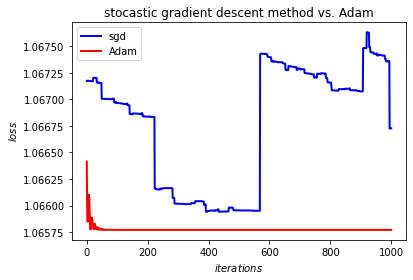

In [ ]:
print(len(sgd))
print(len(adam))

x = np.linspace(0,1000,1000)

plt.plot()
plt.plot(x, sgd, color='b', LineWidth = 2, label='sgd')
plt.plot(x, adam, color='r', LineWidth = 2, label='Adam')

plt.ylabel(r'$loss$')
plt.xlabel(r'$iterations$')
plt.legend()
plt.title('stocastic gradient descent method vs. Adam')

